## Image Analysis - Tests

### Requirements

In [34]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import time
import sys
import os

from matplotlib import pyplot as plt

### Global variables

In [81]:
# General variables

parent_dir = os.getcwd()
timer = time.time()
image_path = os.path.join(parent_dir, 'example_image', 'test_img5.jpg')
image = cv2.imread(image_path)


print('\nDetecting road lines...')
print(image.shape)
# "\\wsl.localhost\Ubuntu-22.04\home\jpregazzi\projects\Panurge2000\codes_arch\python_code_modules\example_image\cross.jpeg"


Detecting road lines...
(1200, 1600, 3)


### Image analysis methods

In [82]:
def warpImg (img,points,w,h,inv=False):
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    if inv:
        matrix = cv2.getPerspectiveTransform(pts2,pts1)
    else:
        matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarp = cv2.warpPerspective(img,matrix,(w,h))
    return imgWarp	

def convert_to_HSV(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    return hsv

def detect_edges(frame):
    hsv = convert_to_HSV(frame)

    lower = np.array([90, 0, 180])
    upper = np.array([170, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    count_black = np.sum(mask <= 10)
    w,h,_ = frame.shape
    
    if count_black > w*h*0.75:
        lower = np.array([0, 0, 170])
        upper = np.array([170, 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
    
    return mask

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus lower half of the image
    polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1/2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

def detect_line_segments(cropped_edges):
    rho = 1  # precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # degree in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes

    line_segments = cv2.HoughLines(cropped_edges, rho, angle, min_threshold,)
    return line_segments

#Get direction of the car based on the line sege
def get_angle(frame,line_segments):

    if line_segments is None:
        return 0,False

    segment = line_segments[0][0]
    height, width,_ = frame.shape
    rho,theta = segment
    a = np.cos(theta)

    if abs(theta - np.pi/2)<np.pi/6:
        return 0,True
    distance = abs(rho/a-height*np.tan(theta))
    if theta > np.pi/2:
        theta = theta - np.pi
    theta = theta * 180 / np.pi
    demi_largeur_camera = width/2
    if abs(distance - demi_largeur_camera) < demi_largeur_camera/20 and abs(theta) > 40:
        return theta*0.5,False
    elif abs(distance - demi_largeur_camera) > demi_largeur_camera/30:
        return (distance - demi_largeur_camera),False
    else:
        return 0,False

def is_intersection(frame):

    # Test if there is an intersection between at least two lines in the cropped frame
    line_segments = cv2.HoughLinesP(frame, 1, np.pi / 180, 10, np.array([]), minLineLength=10, maxLineGap=4)
    if line_segments is None:
        return False, None, None

    #Compute angle between all detected lines and return True if one is greater than 80°
    range_i = np.random.randint(0, len(line_segments), 5)
    for i in range_i:
        for x1, y1, x2, y2 in line_segments[i]:
            if x1 == x2:
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope, intercept = fit
            #range_j = np.random.randint(i+1, len(line_segments), 5)
            for j in range(i+1, len(line_segments)):
                for x1, y1, x2, y2 in line_segments[j]:
                    if x1 == x2:
                        continue
                    fit = np.polyfit((x1, x2), (y1, y2), 1)
                    slope2, intercept2 = fit
                    if abs(slope-slope2) > 70:
                        angle = np.arctan(abs((slope-slope2)/(1+slope*slope2)))*180/np.pi
                        #print(angle)
                        if angle > 80:
                            return True, line_segments[i], line_segments[j]
    return False, None, None

def heading_image(frame, steering_angle, line_color=(0, 255, 0), line_width=5):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    steering_angle_radian = steering_angle / 180.0 * np.pi
    # find the heading line starting from the bottom of the frame
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 + height / 2 * np.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)
    return heading_image

def return_angle(frame):
    frame = cv2.resize(frame, (80, 60))

    hsv = convert_to_HSV(frame)
    edges = detect_edges(hsv)

    #cropped_edges = region_of_interest(edges)
    cropped_edges = edges
    
    line_segments = detect_line_segments(cropped_edges)
    angle,is_inter = get_angle(frame,line_segments)
    heading_im = heading_image(frame,angle)
    #Display the resulting frame, the cropped edges and the lines on the same image
    #plt.imshow(cropped_edges)
    plt.imshow(heading_im)
    
    """
    bool_inter,line1,line2 = is_intersection(cropped_edges)
    print(bool_inter)
    if bool_inter:
        #display intersection on heading image
        for x1, y1, x2, y2 in line1:
            cv2.line(heading_im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for x1, y1, x2, y2 in line2:
            cv2.line(heading_im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        #show on cropped edges
        plt.imshow('heading_image',heading_image)
        print("Intersection at time: ", time.time()-timer)
        #cv2.putText(heading_image, 'Intersection', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    """
    
    return angle

### Tests

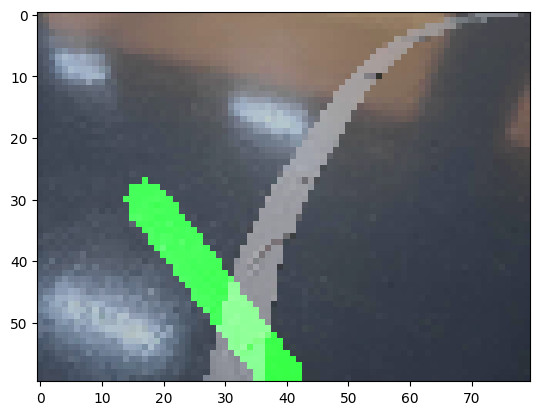

In [83]:
angle = return_angle(image)

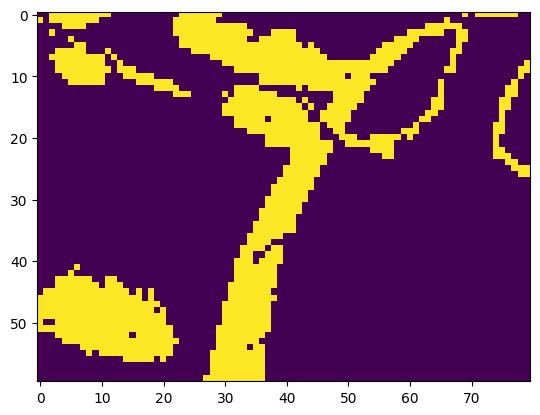

In [84]:
image_resized = cv2.resize(image, (80, 60))
hsv = convert_to_HSV(image_resized)
mask = detect_edges(hsv)
plt.imshow(mask)

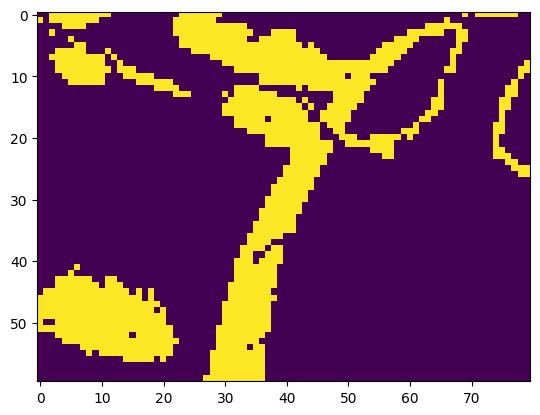

In [85]:
plt.imshow(mask) # image_resized)

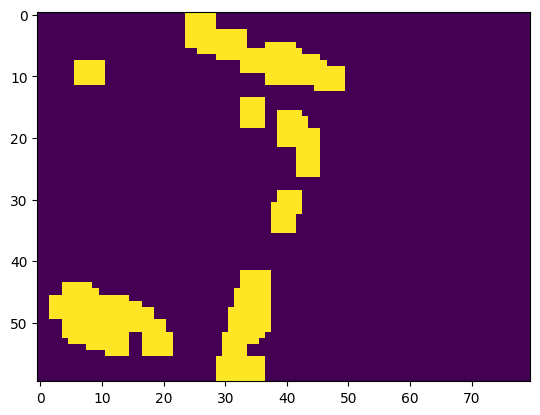

In [91]:
# Remove noise
kernel_erode = np.ones((4,4), np.uint8)

eroded_mask = cv2.erode(mask, kernel_erode, iterations=1)
kernel_dilate = np.ones((4,4), np.uint8)
dilated_mask = cv2.dilate(eroded_mask, kernel_dilate, iterations=1)
plt.imshow(dilated_mask)

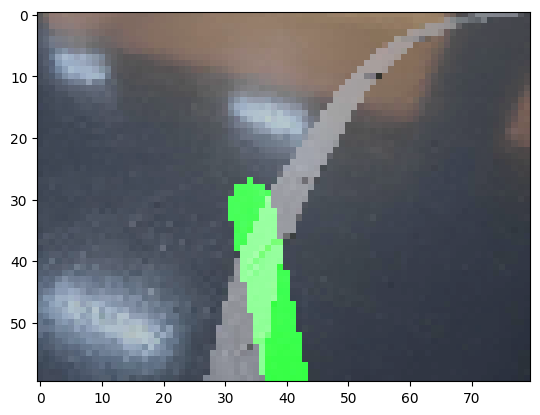

In [92]:
line_segments = detect_line_segments(dilated_mask)

angle,is_inter = get_angle(image_resized, line_segments)
heading_im = heading_image(image_resized, angle)
plt.imshow(heading_im)

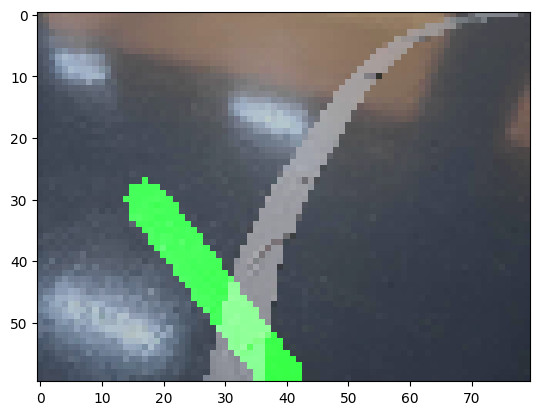

In [93]:
line_segments_original = detect_line_segments(mask)

angle,is_inter = get_angle(image_resized, line_segments_original)
heading_im = heading_image(image_resized, angle)
plt.imshow(heading_im)

In [89]:
""" TEST / DEPLOY
camera = PiCamera()
rawcapture = PiRGBArray(camera,size=(160,120))
time.sleep(0.1)
while True:
    camera.capture(rawcapture, use_video_port=True, resize = (160,120), format="bgr")
    frame = rawcapture.array
    
    angle = return_angle(frame)
    
    key = cv2.waitKey(1)
    rawcapture.truncate(0)
    if key == 27:
        break

        """

' TEST / DEPLOY\ncamera = PiCamera()\nrawcapture = PiRGBArray(camera,size=(160,120))\ntime.sleep(0.1)\nwhile True:\n    camera.capture(rawcapture, use_video_port=True, resize = (160,120), format="bgr")\n    frame = rawcapture.array\n    \n    angle = return_angle(frame)\n    \n    key = cv2.waitKey(1)\n    rawcapture.truncate(0)\n    if key == 27:\n        break\n\n        '